# Turbofan POC - Initial Training and Model Serving

This notebook is creating an initial model for predictions of the RUL for our turbofan engines.

## Imports and Data Preprocessing

In [ ]:
# check if we are inside google colab
try:
    from google.colab import drive
    # mount gdrive for importing the data
    drive.mount('/content/gdrive', force_remount=True)
    # change this path to your notebooks directory inside google drive
    %cd /content/gdrive/My\ Drive/dev/turbofan_poc/notebooks

    # set tensorflow version
    %tensorflow_version 2.x
except:
    pass

In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt
from amdex import *

sns.set()

In [2]:
# load the data 
data_folder_path = '/localstorage-trainer/data'
model_data_path = '/localstorage-trainer/models/train_data_initial.txt'

train_data_path = os.path.join(data_folder_path, 'train_data_initial.txt')
train_data = pd.read_csv(train_data_path)
train_data.set_index('time_in_cycles')

val_data_path = os.path.join(data_folder_path, 'test_data_val.txt')
val_data = pd.read_csv(val_data_path)
val_data.set_index('time_in_cycles')

test_data_path = os.path.join(data_folder_path, 'test_data_test.txt')
test_data = pd.read_csv(test_data_path)
test_data.set_index('time_in_cycles')

# retrieve the max cycles per engine: RUL
train_rul = pd.DataFrame(train_data.groupby('engine_no')['time_in_cycles'].max()).reset_index()
# merge the RULs into the training data
train_rul.columns = ['engine_no', 'max']
train_data = train_data.merge(train_rul, on=['engine_no'], how='left')
# add the current RUL for every cycle
train_data['RUL'] = train_data['max'] - train_data['time_in_cycles']
train_data.drop('max', axis=1, inplace=True)

# test and validation data already contains the RUL values

# drop the columns not needed
cols_nan = train_data.columns[train_data.isna().any()].tolist()
cols_const = [ col for col in train_data.columns if len(train_data[col].unique()) <= 2 ]

# The operational settings 1 and 2 don´t have a trend and they look like random noise.
# Sensors 11, 12, 13 could be removed due to high correlations but it should be tested.
# The trend of sensors 9 and 14 depend on the specific engine. Some engines at the end
# of life tend to increase while others tend to decrease. What is common about these
# two sensors is that the magnitude at the end life gets amplified. We should try
# removing both sensors.
cols_irrelevant = ['operational_setting_1', 'operational_setting_2', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13']

# Drop the columns without or with constant data
train_data = train_data.drop(columns=cols_const + cols_nan + cols_irrelevant)
val_data = val_data.drop(columns=cols_const + cols_nan + cols_irrelevant)
test_data = test_data.drop(columns=cols_const + cols_nan + cols_irrelevant)

## Permission Acquisition

<!-- permission = amdex.training_can_be_executed(userid, datasets[], 'algo description')
if(permission):
    print("training can proceed")
else:
    print("permission denied") -->

## Data Preparation

In [3]:
# define the columns for training
train_data_inputs = train_data.copy()
train_data_inputs.drop(columns=['RUL', 'engine_no', 'time_in_cycles'], inplace=True)
training_columns = train_data_inputs.columns

### Windowing

To do our model training we split the data from an engine into rolling windows so we have the dimensions (total number of rows, time steps per window, feature columns).

*Engine x for window size 3:*

```
[1 2 3 4 5 6] -> [1 2 3], [2 3 4], [3 4 5], [4 5 6]
```

As labels we pick the RUL of the last value in the windowed sequence.

By splitting the data into windows we have to drop data samples that are smaller than the window size. This especially means we can not predict RUL values for smaller time series of engine data. An alternative would be to pad sequences so that we can use shorter ones.

In [4]:
WINDOW_SIZE = 80
BATCH_SIZE = 210

In [5]:
def transform_to_windowed_data(dataset, window_size, window_limit = 0, verbose = True):
  """Transform the dataset into input windows with a label.

  Args:
      dataset (DataFrame): The dataset to tranform.
      window_size (int): The length of the windows to create.
      window_limit (int): The max windows to create for a data subset.

  Returns:
      (numpy.array, numpy.array): A tuple of features and labels.
  """
  features = []
  labels = []

  dataset = dataset.set_index('time_in_cycles')
  data_per_engine = dataset.groupby('engine_no')

  for engine_no, engine_data in data_per_engine:
      # skip if the engines cycles are too few
      if len(engine_data) < window_size + window_limit -1:
        continue

      if window_limit != 0:
        window_count = window_limit
      else:
        window_count = len(engine_data) - window_size

      for i in range(0, window_count):
        # take the last x cycles where x is the window size
        start = -window_size - i
        end = len(engine_data) - i
        inputs = engine_data.iloc[start:end]
        # use the RUL of the last cycle as label
        outputs = engine_data.iloc[end - 1, -1]

        inputs = inputs.drop(['engine_no', 'RUL'], axis=1)

        features.append(inputs.values)
        labels.append(outputs)

  features = np.array(features)
  labels = np.array(labels)
  labels = np.expand_dims(labels, axis=1)

  if verbose:
    print("{} features with shape {}".format(len(features), features[0].shape))
    print("{} labels with shape {}".format(len(labels), labels.shape))

  return features, labels

In [6]:
x_train, y_train = transform_to_windowed_data(train_data, WINDOW_SIZE)
x_val, y_val = transform_to_windowed_data(val_data, WINDOW_SIZE)
x_test, y_test = transform_to_windowed_data(test_data, WINDOW_SIZE)

1256 features with shape (80, 11)
1256 labels with shape (1256, 1)
2601 features with shape (80, 11)
2601 labels with shape (2601, 1)
2982 features with shape (80, 11)
2982 labels with shape (2982, 1)


### Standardization

The data scaling will be embedded in the model so it could be easily applied to inference as well.

### Response Clipping

Since the degradation in a system will generally remain negligible until after some period of operation time the early and higher RUL values are probably unreasonable. We could tackle this by clipping the RUL values.

That means we are fine with our model not correctly predicting RUL values above the *rul_clip_limit*. The model will still correctly identify that these engines but it is kind of cheating as the error for these engines improves.

In [7]:
# clip RUL values
rul_clip_limit = 110

y_train = y_train.clip(max=rul_clip_limit)
y_val = y_val.clip(max=rul_clip_limit)
y_test = y_test.clip(max=rul_clip_limit)

## Model Training

### Helpers

In [8]:
# RMSE implementation
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

### Model Definition

In [9]:
class TurbofanModel(nn.Module):
    def __init__(self, train_mean, train_std):
        super().__init__()
        
        self.train_mean = train_mean
        self.train_std = train_std

        self.fc1 = nn.Linear(len(training_columns), 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 24)
        self.fc4 = nn.Linear(24, 1)

    def to(self, device):
        super().to(device)
        self.train_mean = self.train_mean.to(device)
        self.train_std = self.train_std.to(device)
        
        return self
        
    def forward(self, x):
        # scale the input
        x = (x - self.train_mean) / self.train_std

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x[:, -1, :]
        
        return x

### Prepare Data Loader

In [10]:
# transform to torch tensor
tensor_x_train = torch.Tensor(x_train)
tensor_y_train = torch.Tensor(y_train)
tensor_x_val = torch.Tensor(x_val)
tensor_y_val = torch.Tensor(y_val)
tensor_x_test = torch.Tensor(x_test)
tensor_y_test = torch.Tensor(y_test)

# create datasets for train, test and validation
train_dataset = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val, tensor_y_val)
test_dataset = torch.utils.data.TensorDataset(tensor_x_test, tensor_y_test)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Initial Training

In [11]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()

    running_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    return epoch_loss

In [12]:
def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += criterion(output, target).item() * data.size(0)

    test_loss /= len(test_loader.dataset)

    return test_loss

In [13]:
torch.manual_seed(1)
np.random.seed(51)

epochs = 280

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

mean = tensor_x_train.mean(0)
std = tensor_x_train.std(0)
model = TurbofanModel(mean, std).to(device)

criterion = nn.L1Loss() # mae
optimizer = optim.Adam(model.parameters())

history = {}
history['epoch'] = []
history['loss'] = []
history['val_loss'] = []

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss = test(model, device, val_loader, criterion)

    print('Epoch: {}/{}\tloss: {:.4f}\tval_loss: {:.4f}'.format(epoch, epochs, train_loss, val_loss))

    history['epoch'].append(epoch)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)

Epoch: 1/280	loss: 63.3994	val_loss: 84.2056
Epoch: 2/280	loss: 63.3671	val_loss: 84.1714
Epoch: 3/280	loss: 63.3321	val_loss: 84.1322
Epoch: 4/280	loss: 63.2890	val_loss: 84.0836
Epoch: 5/280	loss: 63.2318	val_loss: 84.0180
Epoch: 6/280	loss: 63.1494	val_loss: 83.9181
Epoch: 7/280	loss: 63.0267	val_loss: 83.7666
Epoch: 8/280	loss: 62.8487	val_loss: 83.5498
Epoch: 9/280	loss: 62.6013	val_loss: 83.2468
Epoch: 10/280	loss: 62.2635	val_loss: 82.8253
Epoch: 11/280	loss: 61.8057	val_loss: 82.2396
Epoch: 12/280	loss: 61.1962	val_loss: 81.4303
Epoch: 13/280	loss: 60.4015	val_loss: 80.3405
Epoch: 14/280	loss: 59.4069	val_loss: 78.9071
Epoch: 15/280	loss: 58.2077	val_loss: 77.0770
Epoch: 16/280	loss: 56.8311	val_loss: 74.7960
Epoch: 17/280	loss: 55.2387	val_loss: 71.9916
Epoch: 18/280	loss: 53.3949	val_loss: 68.5977
Epoch: 19/280	loss: 51.2564	val_loss: 64.5477
Epoch: 20/280	loss: 48.7040	val_loss: 59.7023
Epoch: 21/280	loss: 45.6064	val_loss: 53.8723
Epoch: 22/280	loss: 41.8517	val_loss: 46.85

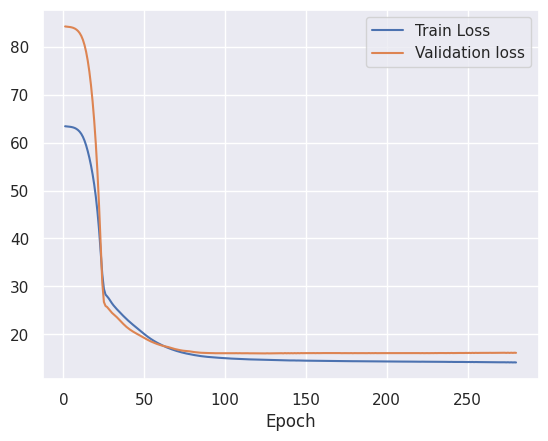

In [14]:
plt.figure()
plt.xlabel('Epoch')
plt.plot(history['epoch'], np.array(history['loss']), label='Train Loss')
plt.plot(history['epoch'], np.array(history['val_loss']), label = 'Validation loss')
plt.legend()

## Model Evaluation

Testing set RMSE:    19.75
Validation set RMSE:   20.09
Training set RMSE:   18.51


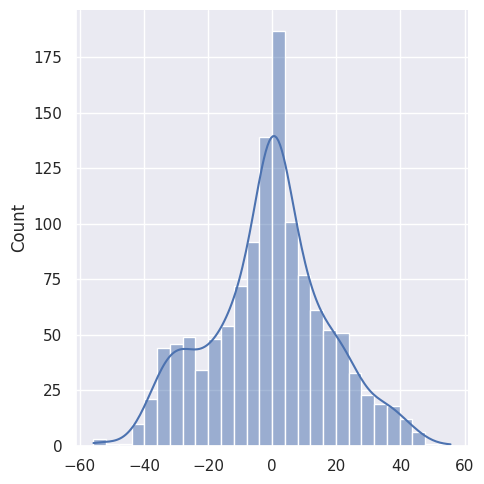

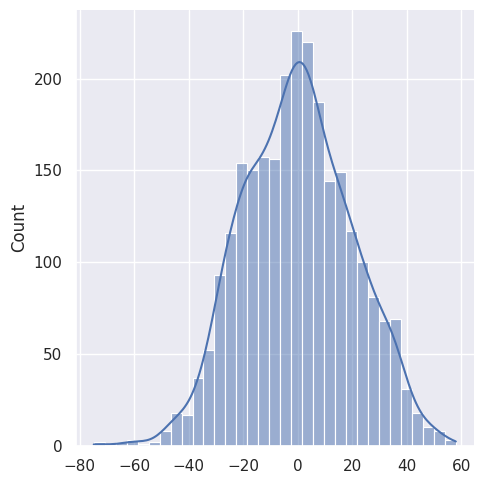

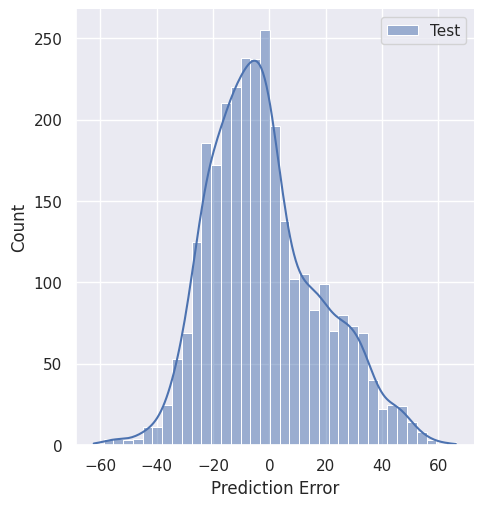

In [15]:
def plot_res(model, test_data, test_labels, val_data, val_labels, train_data, train_labels):
    output_test = model(test_data).to('cpu')
    rmse_test = root_mean_squared_error(test_labels, output_test)
    output_val = model(val_data).to('cpu')
    rmse_val = root_mean_squared_error(val_labels, output_val)
    output_train = model(train_data).to('cpu')
    rmse_train = root_mean_squared_error(train_labels, output_train)
    print("Testing set RMSE:  {:7.2f}".format(rmse_test))
    print("Validation set RMSE: {:7.2f}".format(rmse_val))
    print("Training set RMSE: {:7.2f}".format(rmse_train))

    test_predictions = output_test.flatten()
    val_predictions = output_val.flatten()
    train_predictions = output_train.flatten()

    sns.displot(train_predictions - train_labels.flatten(), label="Train", kde=True)
    sns.displot(val_predictions - val_labels.flatten(), label="Val", kde=True)
    sns.displot(test_predictions - test_labels.flatten(), label="Test", kde=True)

    plt.xlabel("Prediction Error")
    plt.legend()
    plt.show()

tensor_x_train, tensor_x_val, tensor_x_test = tensor_x_train.to(device), tensor_x_val.to(device), tensor_x_test.to(device)

with torch.no_grad():
    plot_res(model, tensor_x_test, tensor_y_test, tensor_x_val, tensor_y_val, tensor_x_train, tensor_y_train)

## Save Model

In [ ]:
# save the model to use it for the federated trainer
model_data+path=""
print(model_data_path, flush=True)
torch.save(model.to('cpu'), model_data_path)